In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root
import scipy.linalg as la
from scipy.interpolate import interp1d
import sys
if ".." not in sys.path: sys.path.append("..")
from common import constants, cosmology

# $\mathrm{B} - \mathrm{L}$ Genesis

## Warning: for different epoch change numbers!

In [2]:
g2 = 0.55
g3 = 0.6

def g_to_alpha(g): return (g / (4*np.pi))**2

alpha_2 = g_to_alpha(g2)
alpha_3 = g_to_alpha(g3)

Y_tau = 1e-2
Y_top = 0.49
Y_bottom = 6.8e-3

kappa_tau = 1.7e-3

def calc_yukawa_rate(T, kappa, Y):
    return kappa * Y**2 * T**4

def calc_yukawa_rate_tau(T):
    return calc_yukawa_rate(T, kappa_tau, Y_tau)

# log log -> no
# log linear -> no

kappa_quarks_uptype = np.array([8e-3, 1e-2, 1.2e-2]) # \approx downtype
T_for_kappa_quarks_uptype = np.array([1e15, 1e12, 1e9])
kappa_quark_uptype_interp = interp1d(T_for_kappa_quarks_uptype, kappa_quarks_uptype)

def calc_yukawa_rate_quark(T, Y):
    kappa = kappa_quarks_uptype[1] # kappa_quark_interp(T)
    return calc_yukawa_rate(T, kappa, Y)

def calc_yukawa_rate_top(T):
    return calc_yukawa_rate_quark(T, Y_top)

def calc_yukawa_rate_bottom(T):
    return calc_yukawa_rate_quark(T, Y_bottom)

In [3]:
def calc_sphaleron_rate(T, N_H, N_c
                        , alpha, N_f=6):
    some_number = 3.041
    g = np.sqrt(4*np.pi*alpha)
    m_D = np.sqrt((2*N_c + N_f + N_H) / 6 * g**2 * T**2)

    def gamma_eq(gamma):
        return gamma - N_c * alpha * T * (np.log(m_D / gamma) + some_number)
    p = - some_number * N_c * alpha * T
    q = - N_c * alpha * T * m_D
    guess = -p/2 + np.sqrt((p/2)**2 - q)
    sol = root(gamma_eq, guess)
    if not sol.success: return np.nan
    gamma = sol.x[0]

    Gamma_sphal = ( 
        0.21 / 2 * (N_c * g**2 * T**2 / m_D**2) * 
        (np.log(m_D / gamma) + some_number) * 
        (N_c**2 - 1) / N_c**2 * 
        (N_c * alpha)**5 * T**4
    )
    return Gamma_sphal

kappa_WS = 24 # for 1e12 GeV
kappa_SS = 2.7e2 # for 1e13 GeV

def calc_weak_sphaleron_rate(T):
    return kappa_WS / 2 * alpha_2**5 * T**4
    # return calc_sphaleron_rate(T, N_H=1, N_c=2, alpha=alpha2_running(T))

def calc_strong_sphaleron_rate(T):
    return kappa_SS / 2 * alpha_3**5 * T**4
    # return calc_sphaleron_rate(T, N_H=0, N_C=3, alpha=alpha3_running(T))

In [4]:
charge_vector = np.array((
    # Interactions:
    # tau, L12, L3, q12, t,  b,  Q12, Q3,  H
    (0,    2,   1,  0,   0,  0,  6,   3,   0), # WS
    (0,    0,   0, -4,  -1, -1,  4,   2,   0), # SS
    (-1,   0,   1,  0,   0,  0,  0,   0,   1), # Y_tau
    (0,    0,   0,  0,  -1,  0,  0,   1,   1), # Y_top
    (0,    0,   0,  0,   0, -1,  0,   1,  -1), # Y_bottom
    (0,    2,   0,  0,   0,  0,  0,   0,   2), # Weinberg_12
    (0,    0,   2,  0,   0,  0,  0,   0,   2), # Weinberg_3
    # Conserved Quantaties:
    # tau, L12,  L3,   q12,   t,    b,  Q12,   Q3,  H
    #( -1, -1/2, -1/2,  1/6,  2/3, -1/3, 1/6,  1/6, 1/2), # Y
    #(  0,  0,    0,    1/3, -2/3, -2/3, 1/3, -2/3, 0),   # B12 - 2*B3
))

In [5]:
g = dofs = np.array([1,4,2,12,3,3,12,6,4])

In [6]:
kappa_W = 3e-3
nu_EW = 174 # [GeV]
m_nu = 0.05 # np.sqrt(2.4e-3)
def calc_weinberg_op_rate(T):
    return kappa_W * m_nu**2 * T**6 / nu_EW**4

In [7]:
def calc_rate_vector(T):
    return np.array((
        calc_weak_sphaleron_rate(T), # WS
        calc_strong_sphaleron_rate(T), # SS
        calc_yukawa_rate_tau(T), # Y_tau
        calc_yukawa_rate_top(T), # Y_top
        calc_yukawa_rate_bottom(T), # Y_bottom
        2 * calc_weinberg_op_rate(T), # W_12
        calc_weinberg_op_rate(T), # W_3
    ))

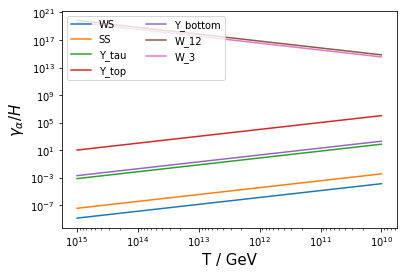

In [8]:
T_RH = 1e15
process_names = ["WS", "SS", "Y_tau", "Y_top", "Y_bottom", "W_12", "W_3"]
T_range = np.geomspace(T_RH, 1e10, 100)
H = cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T_range))
for name, rate in zip(process_names, np.vstack([calc_rate_vector(T) / (T**3 / 6) for T in T_range]).T):
    plt.loglog(T_range, rate / H, label=name)
plt.legend(ncol=2, loc=2)
plt.xlabel("T / GeV", fontsize=15)
plt.ylabel(r"$\gamma_\alpha / H$", fontsize=15)
plt.gca().invert_xaxis()

In [9]:
#                                           WS SS  Ytau Yt Yb  W12  W3 
source_vector_B_minus_L_current = np.array((0,  0,  0,  0,  0, -2, -2))
source_vector_weak_sphaleron    = np.array((1,  0,  0,  0,  0,  0,  0))
source_vector_strong_sphaleron  = np.array((0,  1,  0,  0,  0,  0,  0))

In [10]:
# a dot / f / T
eta0 = -1e-9
def calc_axion_motion(T):
    return eta0

In [11]:
charge_names = ["tau", "L12", "L3", "q12", "t", "b", "Q12", "Q3", "H"]

In [12]:
charge_vector_B_minus_L = np.array((-1, -1, -1, 1/3, 1/3, 1/3, 1/3, 1/3, 0))
def calc_B_minus_L(red_chems):
    return np.dot(charge_vector_B_minus_L, red_chems)

In [13]:
# x = T / u
# y = mu / (T / u)

T_unit = 1e15
red_chem_unit = 1e-10

def transport_eq_rhs(x, y, n_S, n):
    T = x * T_unit
    red_chem_pot = y * red_chem_unit 
    H = cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T))
    gamma = calc_rate_vector(T) / (T**3 / 6)
    axion_motion = calc_axion_motion(T)
    d_red_chem_pot_d_ln_T = np.array([
        1 / g[i] * sum(n[alpha, i] * gamma[alpha] / H * 
                       (np.dot(n[alpha, :], red_chem_pot) - n_S[alpha] * axion_motion) 
                    for alpha in range(n.shape[0]))
            for i in range(n.shape[1])])
    print(d_red_chem_pot_d_ln_T, x, T_unit**2 / red_chem_unit)
    dydx = d_red_chem_pot_d_ln_T * x * T_unit**2 / red_chem_unit
    return dydx

initial = np.repeat(0, charge_vector.shape[1])
T_RH = 1e15
start = T_RH / T_unit
end = 1e10 / T_unit
num_steps = 500
steps = np.geomspace(start, end, num_steps)
steps[0] = start; steps[-1] = end

sol = solve_ivp(transport_eq_rhs, (start, end), initial, 
         args=(source_vector_weak_sphaleron, charge_vector), 
         method="DOP853", rtol=1e-8, t_eval=steps) # methods: RK45, DOP853, Radau, BDF, LSODA

for name, y in zip(charge_names, sol.y):
    plt.loglog(sol.t * T_unit, np.abs(y) * red_chem_unit, label=name)
plt.ylabel(r"$|\mu / T|$")
plt.xlabel(r"T / GeV")
plt.gca().invert_xaxis()
plt.legend(ncol=2)
plt.show()

[0.0000000e+00 6.6087171e-19 6.6087171e-19 0.0000000e+00 0.0000000e+00
 0.0000000e+00 6.6087171e-19 6.6087171e-19 0.0000000e+00] 1.0 1e+40
[ 4.79738058e+02 -4.61794386e+25 -4.61794386e+25  4.69172857e-02
  2.25853157e+06  4.35009423e+02 -5.21583080e-02 -1.12948330e+06
 -6.92691579e+25] 0.999999 1e+40
[ 2.91273287e-03 -2.80379335e+20 -2.80379335e+20  2.84858618e-07
  1.37126897e+01  2.64116266e-03 -3.16679520e-07 -6.85766548e+00
 -4.20569003e+20] 0.9999999999939285 1e+40
[-3.47553790e+36  3.34554883e+59  3.34554883e+59 -2.21691887e+12
 -9.81737234e+39  1.89069262e+36  3.79694108e+30  4.90774083e+39
  5.01832324e+59] 0.9999999999908927 1e+40
[ 6.22063413e+75 -5.98797534e+98 -5.98797534e+98  2.37983225e+51
  1.75714618e+79 -3.38402497e+75 -6.79589232e+69 -8.78403891e+78
 -8.98196302e+98] 0.9999999999863391 1e+40
[-1.16005959e+116  1.11667204e+139  1.11667204e+139 -4.43804789e+091
 -3.27682714e+119  6.31072416e+115  1.26733704e+110  1.63809804e+119
  1.67500806e+139] 0.9999999999674898 1e+

<ipython-input-13-c3efbf5dccf8>:19: RuntimeWarning: overflow encountered in multiply
  dydx = d_red_chem_pot_d_ln_T * x * T_unit**2 / red_chem_unit
<ipython-input-13-c3efbf5dccf8>:19: RuntimeWarning: overflow encountered in true_divide
  dydx = d_red_chem_pot_d_ln_T * x * T_unit**2 / red_chem_unit


ValueError: need at least one array to concatenate

In [ ]:
# x = log(T)
# y = mu/T

def transport_eq_rhs(log_T, red_chem_pot, n_S, n):
    T = np.exp(log_T)
    # red_chem_pot = np.exp(log_red_chem) 
    H = cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T))
    gamma = calc_rate_vector(T) / (T**3 / 6)
    axion_motion = calc_axion_motion(T)
    d_red_chem_pot_d_ln_T = np.array([
        1 / g[i] * sum(n[alpha, i] * gamma[alpha] / H * 
                       (np.dot(n[alpha, :], red_chem_pot) - n_S[alpha] * axion_motion) 
                    for alpha in range(n.shape[0]))
            for i in range(n.shape[1])])
    return d_red_chem_pot_d_ln_T

initial = np.repeat(1e-15, charge_vector.shape[1])
T_RH = 1e15
start = np.log(T_RH)
end = np.log(1e10)
num_steps = 500
steps = np.linspace(start, end, num_steps)
steps[0] = start; steps[-1] = end

sol = solve_ivp(transport_eq_rhs, (start, end), initial, 
         args=(source_vector_weak_sphaleron, charge_vector), 
         method="Radau", rtol=1e-8, t_eval=steps) # methods: RK45, DOP853, Radau, BDF, LSODA

for name, y in zip(charge_names, sol.y):
    plt.loglog(np.exp(sol.t), y, label=name)
plt.ylabel(r"$|\mu / T|$")
plt.xlabel(r"T / GeV")
plt.gca().invert_xaxis()
plt.legend(ncol=2)
plt.show()

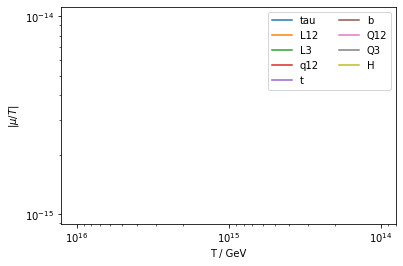

In [14]:
# x = T
# y = log(mu/T)

T_unit = 1e15

def transport_eq_rhs(x, y, n_S, n):
    T = x * T_unit
    red_chem_pot = np.exp(y)
    H = cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T))
    gamma = calc_rate_vector(T) / (T**3 / 6)
    axion_motion = calc_axion_motion(T)
    d_red_chem_pot_d_ln_T = np.array([
        1 / g[i] * sum(n[alpha, i] * gamma[alpha] / H * 
                       (np.dot(n[alpha, :], red_chem_pot) - n_S[alpha] * axion_motion) 
                    for alpha in range(n.shape[0]))
            for i in range(n.shape[1])])
    return d_red_chem_pot_d_ln_T / (x * y)

initial = np.repeat(np.log(1e-15), charge_vector.shape[1])
T_RH = 1e15
start = T_RH / T_unit
end = 1e10 / T_unit
num_steps = 500
steps = np.geomspace(start, end, num_steps)
steps[0] = start; steps[-1] = end

sol = solve_ivp(transport_eq_rhs, (start, end), initial, 
         args=(source_vector_weak_sphaleron, charge_vector), 
         method="Radau", rtol=1e-8, t_eval=steps) # methods: RK45, DOP853, Radau, BDF, LSODA

for name, y in zip(charge_names, sol.y):
    plt.loglog(sol.t * T_unit, np.exp(y), label=name)
plt.ylabel(r"$|\mu / T|$")
plt.xlabel(r"T / GeV")
plt.gca().invert_xaxis()
plt.legend(ncol=2)
plt.show()

In [19]:
# x = ln(T)
# y = log(mu/T)

def transport_eq_rhs(x, y, n_S, n):
    T = np.exp(x)
    red_chem_pot = np.exp(y)
    H = cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T))
    gamma = calc_rate_vector(T) / (T**3 / 6)
    axion_motion = calc_axion_motion(T)
    d_red_chem_pot_d_ln_T = np.array([
        1 / g[i] * sum(n[alpha, i] * gamma[alpha] / H *
                       (np.dot(n[alpha, :], red_chem_pot) - n_S[alpha] * axion_motion)
                    for alpha in range(n.shape[0]))
            for i in range(n.shape[1])])
    dydx = d_red_chem_pot_d_ln_T / red_chem_pot
    return dydx

initial = np.repeat(np.log(1e-14), charge_vector.shape[1]) 
T_RH = 1e15
start = np.log(T_RH)
end = np.log(1e10)
num_steps = 500
steps = np.linspace(start, end, num_steps)
steps[0] = start; steps[-1] = end

sol = solve_ivp(transport_eq_rhs, (start, end), initial,
         args=(source_vector_weak_sphaleron, charge_vector),
         method="DOP853", rtol=1e-5, t_eval=steps) # methods: RK45, DOP853, Radau, BDF, LSODA

for name, y in zip(charge_names, sol.y):
    plt.loglog(np.exp(sol.t), np.abs(np.exp(y)), label=name)
plt.ylabel(r"$|\mu / T|$")
plt.xlabel(r"T / GeV")
plt.gca().invert_xaxis()
plt.legend(ncol=2)
plt.show()


[1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14]
[1.00000000e-14 6.25561590e-15 6.25561590e-15 1.00000000e-14
 1.00000000e-14 1.00000000e-14 1.00000000e-14 1.00000000e-14
 4.94771998e-15]
[1.e-14 0.e+00 0.e+00 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 0.e+00]
[1.e-14 0.e+00    inf 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14    inf]
[nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan]


<ipython-input-19-c567a62dac9f>:16: RuntimeWarning: divide by zero encountered in true_divide
  dydx = d_red_chem_pot_d_ln_T / red_chem_pot
<ipython-input-19-c567a62dac9f>:12: RuntimeWarning: invalid value encountered in double_scalars
  1 / g[i] * sum(n[alpha, i] * gamma[alpha] / H *


ValueError: need at least one array to concatenate

In [ ]:
def transport_eq_rhs(log_T, chem_pot, n_S, n):
    T = np.exp(log_T)
    H = cosmology.calc_hubble_parameter(cosmology.calc_radiation_energy_density(T))
    Gamma = calc_rate_vector(T)
    gamma = rate_per_time_vol_to_rate_per_time(Gamma, T)
    axion_motion = calc_axion_motion(T)
    d_red_chem_pot_d_ln_T = np.array([
        1 / g[i] * sum(n[alpha, i] * gamma[alpha] / H * 
                       (sum(n[alpha, j] * chem_pot[j] / T for j in range(n.shape[1])) 
                        - n_S[alpha] * axion_motion) 
                    for alpha in range(n.shape[0]))
            for i in range(n.shape[1])])
    d_chem_pot_d_ln_T = chem_pot + d_red_chem_pot_d_ln_T * T
    #print(d_chem_pot_d_ln_T)
    return d_chem_pot_d_ln_T